# Swarm EFI TIICT - VirES demo

This notebook demostrates access to EFI TII-CT data via the VirES server API.

1 month of TII-CT data (January 2016, both 2Hz and 16Hz) has been loaded to the VirES DISC server.


In [1]:
SERVER_URL = 'https://staging.viresdisc.vires.services/ows'
SPACECRAFT = 'A'
TIME = '2016-01-10T01:00:00Z'
TIME_MIN = '2016-01-01T00:00:00Z'
TIME_MAX = '2016-02-01T00:00:00Z'

In [2]:
from viresclient import SwarmRequest
from viresclient._wps.time_util import parse_datetime

SwarmRequest.COLLECTIONS['EFI_TII_TC_EXPT03'] = (
    ['SW_EXPT_EFI{}_TCT02'.format(x) for x in 'ABC'] +
    ['SW_EXPT_EFI{}_TCT16'.format(x) for x in 'ABC']
)

SwarmRequest.PRODUCT_VARIABLES['EFI_TII_TC_EXPT03'] = [
    'VsatC', 'VsatE', 'VsatN',
    'Bx', 'By', 'Bz',
    'Ehx', 'Ehy', 'Ehz',
    'Evx', 'Evy', 'Evz',
    'Vicrx', 'Vicry', 'Vicrz',
    'Vixv', 'Vixh', 'Viy', 'Viz',
    'Vixv_error', 'Vixh_error', 'Viy_error', 'Viz_error',
    'Calibration_flags',
    'Quality_flags',
]

request = SwarmRequest(SERVER_URL)

# get orbit for the given time
orbit_number = request.get_orbit_number(SPACECRAFT, parse_datetime(TIME))
start_time, end_time =  request.get_times_for_orbits(SPACECRAFT, orbit_number, orbit_number)
print('Spacecraft:     ', SPACECRAFT)
print('Orbit number:   ', orbit_number)
print('Start time:     ', start_time)
print('End time:       ', end_time)

collection_2Hz = 'SW_EXPT_EFI{}_TCT02'.format(SPACECRAFT)
print('Collection 2Hz: ', collection_2Hz)

collection_16Hz = 'SW_EXPT_EFI{}_TCT16'.format(SPACECRAFT)
print('Collection 16Hz:', collection_16Hz)


Spacecraft:      A
Orbit number:    11942
Start time:      2016-01-09 23:42:42.389253
End time:        2016-01-10 01:16:17.457126
Collection 2Hz:  SW_EXPT_EFIA_TCT02
Collection 16Hz: SW_EXPT_EFIA_TCT16


In [3]:
# retrieve temporal coverage

request.set_collection(collection_2Hz)
request.set_products(                                                        
    measurements=[],
    sampling_step='PT5M',
)
locations_2Hz = request.get_between(
    start_time=TIME_MIN,
    end_time=TIME_MAX,
    asynchronous=True,
).as_xarray()

request.set_collection(collection_16Hz)
request.set_products(                                                        
    measurements=[],
    sampling_step='PT5M',
)
locations_16Hz = request.get_between(
    start_time=TIME_MIN,
    end_time=TIME_MAX,
    asynchronous=True,
).as_xarray()


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.102MB)
[1/1] Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.102MB)


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


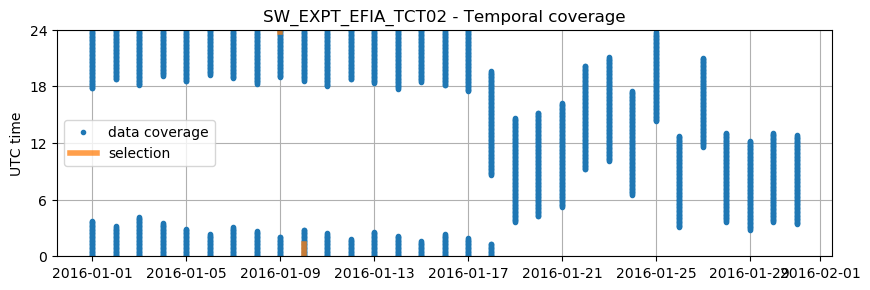

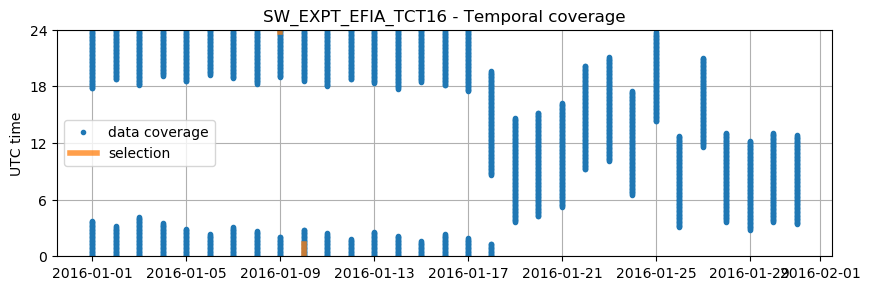

In [4]:
# plot temporal coverage

from numpy import array, arange
from matplotlib.pyplot import subplot, figure

def split_time(times):
    "Split time to date and time in hours."
    days = times.astype('datetime64[D]')
    return days, (times.astype('datetime64[s]') - days).astype('int')/3600

def as_time_array(start, end):
    return array([start, end], 'datetime64[s]')

def split_segments(days, times):
    if times[1] < times[0]:
        return [
            (days[[0, 0]], array([times[0], 24])), 
            (days[[1, 1]], array([0, times[1]])),
        ]
    return [(days, times)]


def plot_temporal_coverage(data, collection):
    fig = figure(figsize=(10, 3), dpi=100)
    ax = subplot(1, 1, 1)
    times = data['Timestamp'].values
    ax.set_title("{} - Temporal coverage".format(collection))
    h_data, = ax.plot(*split_time(times), '.')
    for segment in split_segments(*split_time(as_time_array(start_time, end_time))):
        h_selection, = ax.plot(*segment, '-', c='tab:orange', lw=4, alpha=0.75)
    ax.set_ylim(0, 24)
    ax.set_yticks([0, 6, 12, 18, 24])
    ax.set_ylabel("UTC time")
    ax.grid()
    ax.legend([h_data, h_selection], ["data coverage", "selection"])


plot_temporal_coverage(locations_2Hz, collection_2Hz)
plot_temporal_coverage(locations_16Hz, collection_16Hz)


In [5]:
# retrieve 2Hz data
request.set_collection(collection_2Hz)
request.set_products(                                                        
    measurements=request.PRODUCT_VARIABLES['EFI_TII_TC_EXPT03'],
    auxiliaries=['QDLat', 'MLT'],
)
data_2Hz = request.get_between(
    start_time=start_time,
    end_time=end_time,
    asynchronous=False,
).as_xarray()

print(data_2Hz)


# retrieve 2Hz data
request.set_collection(collection_16Hz)
request.set_products(                                                        
    measurements=request.PRODUCT_VARIABLES['EFI_TII_TC_EXPT03'],
    auxiliaries=['QDLat', 'MLT'],
)
data_16Hz = request.get_between(
    start_time=start_time,
    end_time=end_time,
    asynchronous=False,
).as_xarray()

print(data_16Hz)

      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (1.551MB)


<xarray.Dataset>
Dimensions:            (Timestamp: 11229)
Coordinates:
  * Timestamp          (Timestamp) datetime64[ns] 2016-01-09T23:42:42.725250006 ... 2016-01-10T01:16:17.225250006
Data variables:
    Spacecraft         (Timestamp) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    VsatE              (Timestamp) float32 -144.23048 -144.22871 ... -144.37796
    By                 (Timestamp) float32 3451.5122 3450.0886 ... 4480.6567
    Radius             (Timestamp) float32 6828557.5 6828552.0 ... 6828430.0
    Ehx                (Timestamp) float32 -1.0180848 -1.0066901 ... 0.33369815
    Ehz                (Timestamp) float32 1.3679098 1.3706719 ... -3.046632
    Vixv               (Timestamp) float32 773.95544 796.45166 ... 809.45044
    Vixv_error         (Timestamp) float32 32.779305 32.779305 ... 29.658152
    Calibration_flags  (Timestamp) uint32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    MLT                (Timestamp) float64 16.37 16.37 16.37 ... 16.41 16.41
    QDLat         

      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (12.159MB)


<xarray.Dataset>
Dimensions:            (Timestamp: 89842)
Coordinates:
  * Timestamp          (Timestamp) datetime64[ns] 2016-01-09T23:42:42.443749905 ... 2016-01-10T01:16:17.443749905
Data variables:
    Spacecraft         (Timestamp) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    VsatE              (Timestamp) float32 -144.23132 -144.23112 ... -144.37737
    By                 (Timestamp) float32 3452.3247 3452.1426 ... 4480.215
    Radius             (Timestamp) float32 6828560.5 6828559.5 ... 6828428.0
    Ehx                (Timestamp) float32 -0.57862335 ... -0.029373594
    Ehz                (Timestamp) float32 2.0977516 2.496041 ... -1.6234763
    Vixv               (Timestamp) float32 793.8405 733.26605 ... 883.2752
    Vixv_error         (Timestamp) float32 92.71388 92.71388 ... 83.88592
    Calibration_flags  (Timestamp) uint32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    MLT                (Timestamp) float64 16.37 16.37 16.37 ... 16.41 16.41
    QDLat              (Timestam

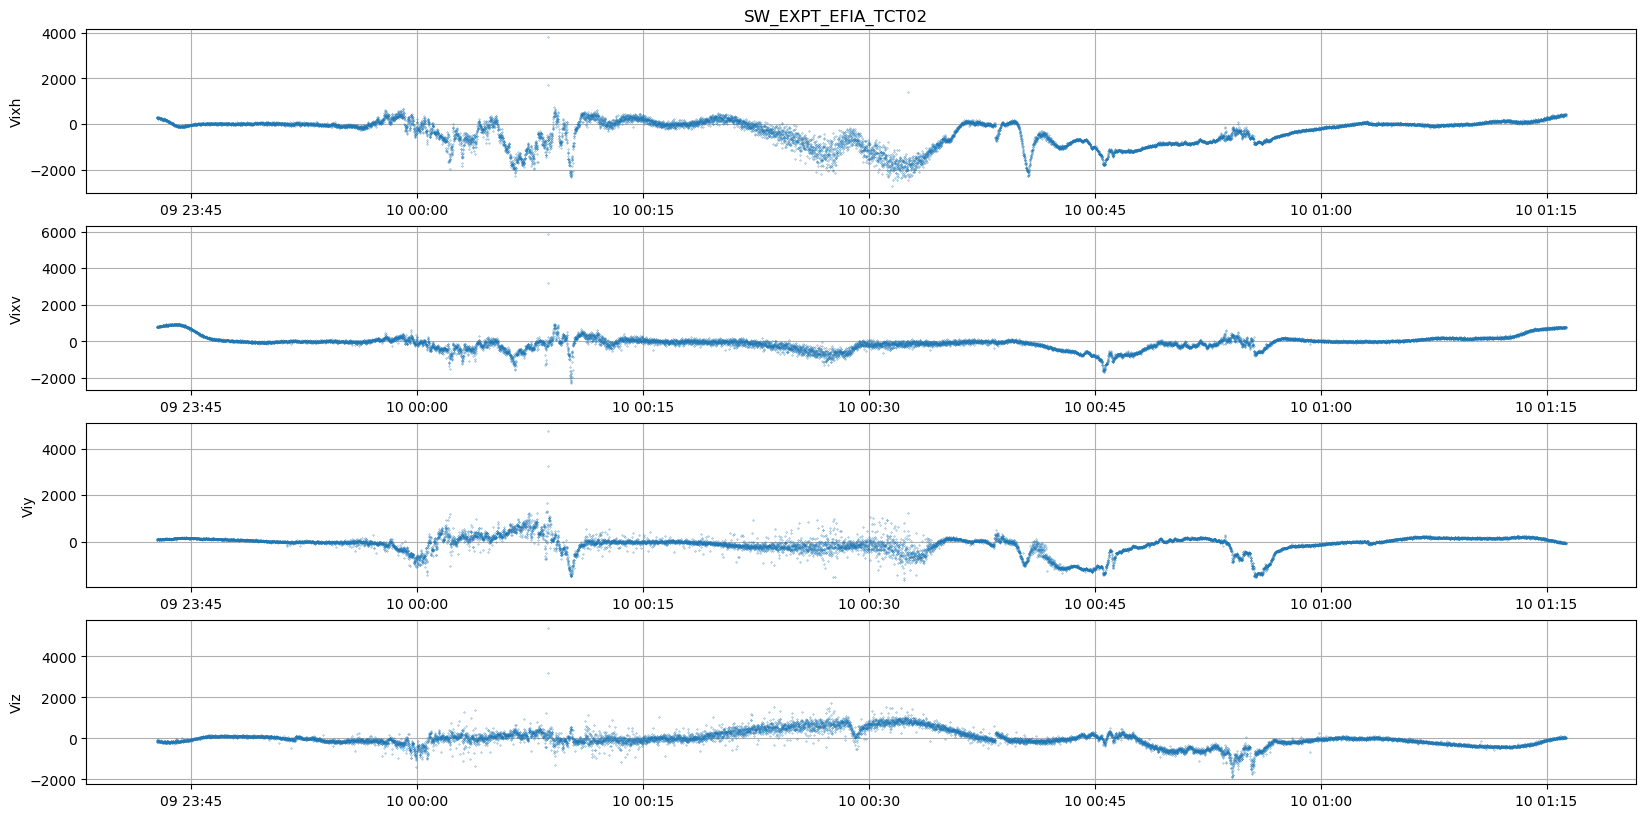

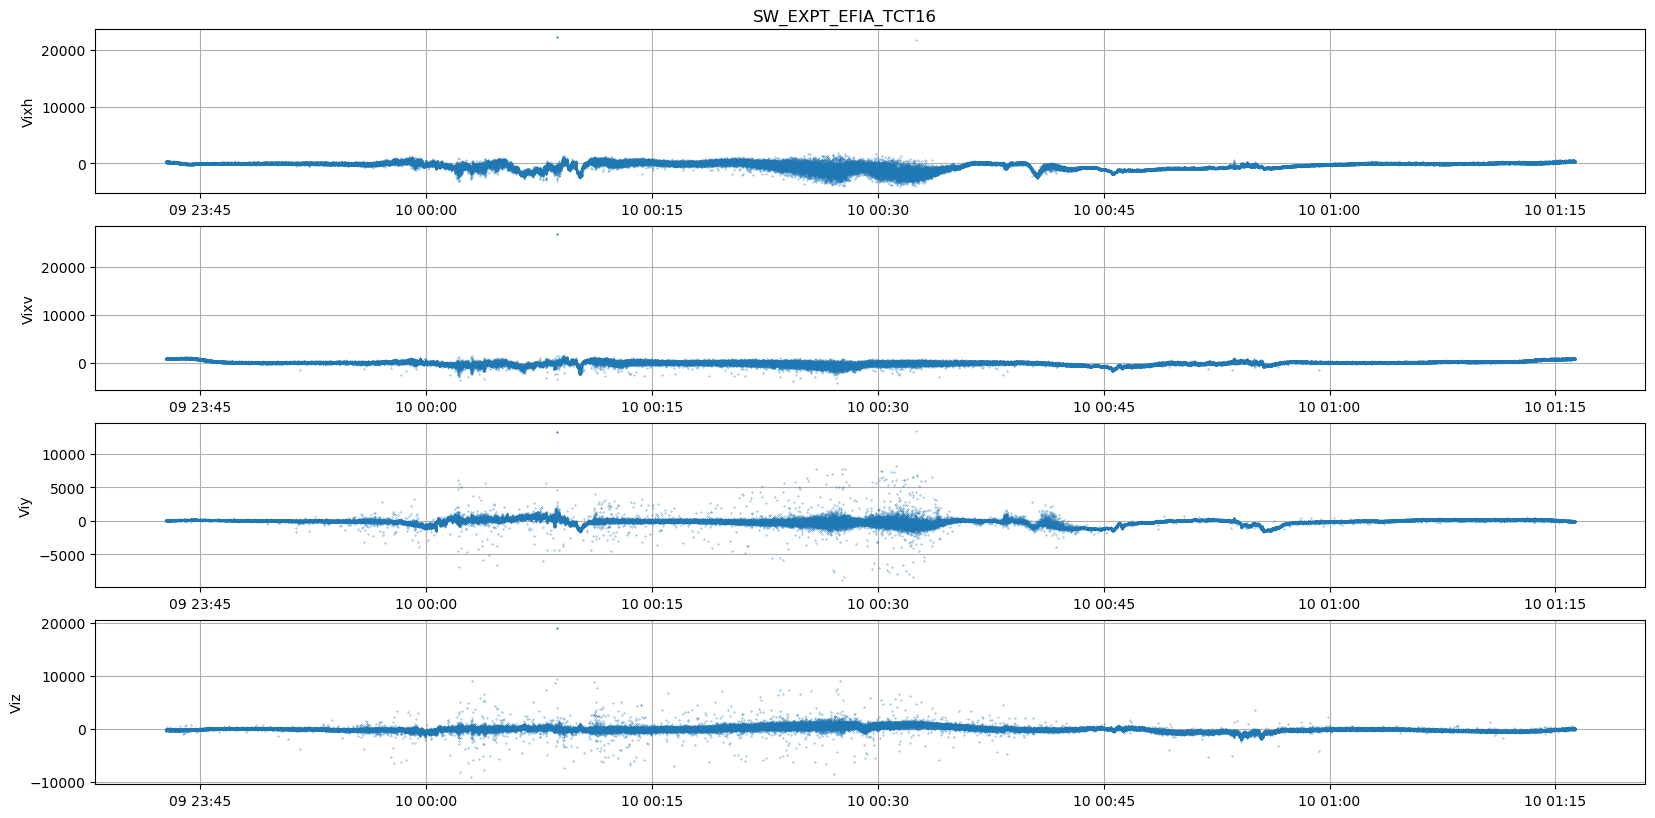

In [6]:
# plot temporal coverage

from numpy import array, arange
from matplotlib.pyplot import subplot, figure

def plot_data(data, collection):
    prm = dict(
        ms=0.5
    )
    
    times = data['Timestamp'].values
    vixh = data['Vixh'].values
    vixv = data['Vixv'].values
    viy = data['Viy'].values
    viz = data['Viz'].values
    
    fig = figure(figsize=(20, 10), dpi=100)
    fig.suptitle(collection, y=0.9)
    
    ax = subplot(4, 1, 1)
    ax.plot(times, vixh, '.', **prm)
    ax.set_ylabel('Vixh')
    ax.grid()

    ax = subplot(4, 1, 2)
    ax.plot(times, vixv, '.', **prm)
    ax.set_ylabel('Vixv')
    ax.grid()

    ax = subplot(4, 1, 3)
    ax.plot(times, viy, '.', **prm)
    ax.set_ylabel('Viy')
    ax.grid()
    
    ax = subplot(4, 1, 4)
    ax.plot(times, viz,  '.', **prm)
    ax.set_ylabel('Viz')
    ax.grid()

    
plot_data(data_2Hz, collection_2Hz)
plot_data(data_16Hz, collection_16Hz)